# Data porcessing of continuos glucose measurements

In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os

## Load dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls -lrth '/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/'

total 1.2G
-rw------- 1 root root 121M Dec  9 18:46 noisy0.0_train.npy
-rw------- 1 root root  16M Dec  9 18:46 noisy0.0_test.npy
-rw------- 1 root root  16M Dec  9 18:46 noisy0.0_vad.npy
-rw------- 1 root root 2.2M Dec 16 11:53 patient1_measurements.csv
-rw------- 1 root root 9.2M Dec 16 11:53 patient0_measurements.csv
-rw------- 1 root root 611M Dec 18 10:22 noise_0.1_train_replace_True.npy
-rw------- 1 root root  26M Dec 18 10:22 noise_0.1_vad_replace_True.npy
-rw------- 1 root root  25M Dec 18 10:22 noise_0.1_test_replace_True.npy
-rw------- 1 root root 565K Dec 23 13:25 patient2_measurements.csv
-rw------- 1 root root  35M Dec 24 12:57 noise_0.0_vad_replace_False.npy
-rw------- 1 root root  34M Dec 24 12:57 noise_0.0_test_replace_False.npy
-rw------- 1 root root 285M Dec 24 12:57 noise_0.0_train_replace_False.npy


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/"

columns = 'Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades)'
columns = columns.split(',')

list_df = []
for i in np.arange(3):
  filename = 'patient%s_measurements.csv' % i
  data_file = os.path.join(root, filename)

  df_ = pd.read_csv(data_file, sep=',', header=None, encoding='utf-8', low_memory=False)
  while len(df_.columns)>len(columns):
    df_.drop(columns=[len(columns)], inplace=True)
  df_.columns = columns
  
  df_['id'] = i
  print("For patient %s the df has shape %s" %(i, df_.shape))
  list_df.append(df_)

df = pd.concat(list_df)
print("The final df has shape: ",  df.shape)
df.head()


For patient 0 the df has shape (103357, 20)
For patient 1 the df has shape (23483, 20)
For patient 2 the df has shape (13225, 20)
The final df has shape:  (140065, 20)


,Medidor,Número de serial,Sello de tiempo del medidor,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Insulina de acción rápida (unidades),Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Insulina de acción larga (unidades),Notas,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades),id
0,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 5:40 pm,0.0,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 5:55 pm,0.0,159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:10 pm,0.0,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:25 pm,0.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,LibreLink,2b3982f5-45fa-4396-8726-78a4651e35cb,06-06-2017 6:40 pm,0.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [0]:
df.describe()

,Tipo de registro,Historial de glucosa(mg/dL),Escaneo de glucosa(mg/dL),Insulina de acción rápida no numérica,Alimento no numérico,Carbohidratos (gramos),Carbohidratos (porciones),Insulina de acción larga no numérica,Tira reactiva para glucosa(mg/dL),Cuerpos cetónicos(mmol/L),Comida e insulina (unidades),Insulina de corrección (unidades),Insulina del cambio de usuario (unidades),id
count,140055.000000,125816.000000,14212.000000,0.0,3.0,1.0,0.0,0.0,12.000000,0.0,0.0,0.0,0.0,140065.000000
mean,0.102160,178.817440,163.849986,NaN,1.0,40.0,NaN,NaN,147.333333,NaN,NaN,NaN,NaN,0.356499
std,0.306469,78.065378,81.779618,NaN,0.0,NaN,NaN,NaN,82.586961,NaN,NaN,NaN,NaN,0.646723
min,0.000000,40.000000,40.000000,NaN,1.0,40.0,NaN,NaN,40.000000,NaN,NaN,NaN,NaN,0.000000
25%,0.000000,118.000000,98.000000,NaN,1.0,40.0,NaN,NaN,67.750000,NaN,NaN,NaN,NaN,0.000000
50%,0.000000,168.000000,150.000000,NaN,1.0,40.0,NaN,NaN,156.000000,NaN,NaN,NaN,NaN,0.000000
75%,0.000000,229.000000,217.000000,NaN,1.0,40.0,NaN,NaN,228.500000,NaN,NaN,NaN,NaN,1.000000
max,6.000000,500.000000,500.000000,NaN,1.0,40.0,NaN,NaN,257.000000,NaN,NaN,NaN,NaN,2.000000


## Choose features and format timestamps


In [0]:
def parser(t):
    if "/" in t:
        out = pd.to_datetime(t, dayfirst=False, format='%Y/%m/%d %H:%M')
    elif "-" in t:
        out = pd.to_datetime(t, dayfirst=False, format='%m-%d-%Y %I:%M %p')
    else: 
        out = None
    return out

In [0]:
# choose variables
dfs = df[['id', 'Sello de tiempo del medidor', 'Historial de glucosa(mg/dL)']]
dfs.columns = ['id', 'timestamp', 'aut_record']
# format records and drop nans
dfs = dfs.dropna(inplace=False, subset=['aut_record'])
dfs.aut_record = dfs.aut_record.values.astype(np.int)

# format timestamp
# dfs.timestamp = pd.to_datetime(dfs.timestamp, dayfirst=False, format='%m-%d-%Y %I:%M %p')
dfs.timestamp = dfs.timestamp.apply(parser)
dfs = dfs.dropna(inplace=False, subset=['timestamp'])

# sort values by id and timestamp
dfs.sort_values(by=['id', 'timestamp'], inplace=True)
dfs = dfs.reset_index()
dfs.drop(columns=['index'], inplace=True)
dfs

,id,timestamp,aut_record
0,0,2016-08-24 15:20:00,194
1,0,2016-08-24 15:35:00,164
2,0,2016-08-24 15:50:00,126
3,0,2016-08-24 16:05:00,87
4,0,2016-08-24 16:20:00,65
...,...,...,...
125811,2,2019-12-22 13:31:00,242
125812,2,2019-12-22 13:46:00,231
125813,2,2019-12-22 14:01:00,212
125814,2,2019-12-22 14:16:00,191


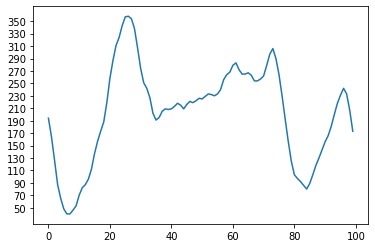

In [0]:
plt.figure()
plt.plot(dfs.aut_record.values[:100])
yaxis = np.arange(50, 360, step=20)
plt.yticks(yaxis, yaxis)
plt.show()

In [0]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

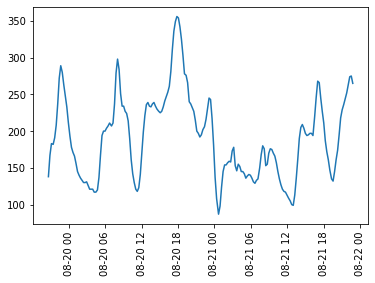

In [0]:
plt.figure()
start=np.random.randint(low=0, high=dfs.index.size)
N = 200
plt.plot(dfs.timestamp.values[start:start+N], dfs.aut_record.values[start:start+N])
plt.gcf().canvas.draw()

ax = plt.gca()
label = ax.get_xticklabels()
label = [l.get_text() for l in label]
ax.set_xticklabels(label, rotation=90)
plt.show()

## Sequence creation


In [0]:
one_day = np.timedelta64(1000000000*3600*24, 'ns')
one_hour = np.timedelta64(1000000000*3600, 'ns')
day_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
            'Friday': 4, 'Saturday': 5, 'Sunday': 6}

def get_time_data(data, idx, time_unit, zero_time=None):
    # get time feature, substract last time feature event, and normalize to time_unit
    ts = pd.to_datetime(data.timestamp.values[idx])
    hour = np.array([t.hour/24.0 for t in ts])
    day = np.array([day_dict[t.day_name()]/7.0 for t in ts])
    if not zero_time:
        zero_time = ts[-1]
    ts = np.array([(t-zero_time)/time_unit for t in ts])
    return hour, day, zero_time, ts

def get_sugar_data(data, idx, scaler=None):
    ys = data.aut_record.values[idx].astype(np.float)
    if not scaler:
        min_ys = ys.min()
        max_ys = ys.max()
        scaler = (min_ys, max_ys)
    ys = (ys-scaler[0]) / (scaler[1] - scaler[0])
    return scaler, ys
    
def add_noise(y, noise=0.0):
    noisy_seq = np.random.normal(loc=0.0, scale=noise, size=y.size)
    y_noisy = y + noisy_seq
    return y_noisy
        
def create_sequence(data, start, history, future, feature_steps=1, label_steps=1, 
                    time_unit=one_day, noise=0.1, day_dict=day_dict):
    # get feature and label index ranges
    feature_range = np.arange(start=start, stop=start+history, step=feature_steps)
    label_range = np.arange(start=start+history, stop=start+history+future, step=label_steps)
    
    hour_feature, day_feature, zero_time, ts_feature = get_time_data(data, feature_range, time_unit, 
                                                                     zero_time=None)
    scaler, ys_feature = get_sugar_data(data, feature_range, scaler=None)
    ys_feature_noisy = add_noise(ys_feature, noise) if noise > 0. else ys_feature
    # put together the sugar_level, hour, day and time_interval
    comb_feature = np.stack(arrays=(ts_feature, hour_feature, day_feature, ys_feature_noisy), axis=1)
    
    hour_label, day_label, _, ts_label = get_time_data(data, label_range, time_unit, zero_time=zero_time)
    _, ys_label = get_sugar_data(data, label_range, scaler=scaler)
    comb_label = np.stack(arrays=(ts_label,hour_label, day_label, ys_label), axis=1)
    
    return ys_feature, comb_feature, comb_label        

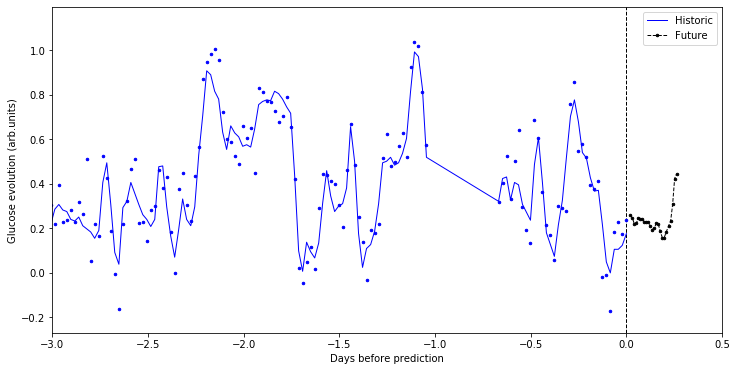

In [0]:
plt.figure(figsize=(12, 6))
start=np.random.randint(low=0, high=dfs.index.size)
# data is sampled every 5 minutes. Thus, there are 4 measurements per hour
history = 72*4 # a history of 3 days
history_steps = 2 # 2 samples per hour
future = 6*4  # this accounts for a prediction of 6 hours in advance
future_steps = 1 # two samples per hour
yf, ynf, yl = create_sequence(dfs, start=start, history=history, future=future, 
                              feature_steps=history_steps, label_steps=future_steps,
                              time_unit=one_day, noise=0.1, day_dict=day_dict)

ymin = ynf[:, 3].min()-0.1
ymax = ynf[:, 3].max()+0.1

plt.plot(ynf[:, 0], yf, '-b', markersize=2, linewidth=1, label='Historic')
plt.plot(ynf[:, 0], ynf[:, 3], '.b', markersize=5, linewidth=1)
plt.plot(yl[:, 0], yl[:, 3], '.--k', markersize=5, linewidth=1, label='Future')
plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

plt.ylim(ymin, ymax)
plt.xlim(-history/4/24, 0.5)

plt.ylabel('Glucose evolution (arb.units)')
plt.xlabel('Days before prediction')
plt.legend(loc='best')
plt.show()

## Split in train, vad and test


In [0]:
def create_dataset(data, num_samples, min_idx, max_idx, history, future, 
                   feature_steps=1, label_steps=1, replace=False,
                   noise=0.1, time_unit=one_day, day_dict=day_dict, 
                   time_tolerance=1.2, length_tolerance=1.2,
                   seed=1098, verbose=False):
    # get all possible start indices
    indices = data.index[min_idx: max_idx-history-future+1]
    # generate num_samples starting indices
    np.random.seed(seed)
    starts = np.random.choice(indices, size=num_samples, replace=replace)
    # output np array
    out = np.zeros(shape=(num_samples, history//feature_steps + future//label_steps, 4), dtype=np.float32)
    # maximum attainable time for a sequence to be added 
    max_time_history = history*0.25*one_hour/one_day
    max_time_future = history*0.25*one_hour/one_day
    k = 0
    for i, start in enumerate(starts):
        _, ynf, yl = create_sequence(data, start=start, history=history, future=future, 
                                     feature_steps=feature_steps, label_steps=label_steps, 
                                     time_unit=one_day, noise=noise, day_dict=day_dict)
        
        # conditions on maximum time
        cond1 = -np.min(ynf[:, 0])/max_time_history < time_tolerance
        cond2 = np.min(yl[:, 0])/max_time_future < time_tolerance

        # conditions on minimum number of points
        cond3 = (history / feature_steps) / ynf[:, 0].size < length_tolerance
        cond4 = (future / label_steps) / yl[:, 0].size < length_tolerance
        
        if cond1 and cond2 and cond3 and cond4:
            out[k] = np.concatenate([ynf, yl], axis=0)
            k += 1
        else: 
            out = np.delete(out, k, 0)
        if k % 1000 == 0 and k > 0 and verbose:
            print("\t Scanned %s sequences; added %s sequences" %(i+1, k))
    s = "%s sequences (out of %s) couldn't been added because they exceed "
    s += "the maximum attainable time (%0.2f and %0.2f). We have added %s sequences in total" 
    print(s %(i+1-k, i+1, max_time_history, max_time_future, k))
    return out

In [0]:
# data is sampled every 5 minutes. Thus, there are 4 measurements per hour
history = 48*4 # a history of 2 days
history_steps = 1 # 4 samples per hour
future = 3*4  # this accounts for a prediction of 3 hours in advance
future_steps = 1 # 4 samples per hour

seed = 17082
noise = 0.0
time_tol = 1.1 # tolerance for jumps in recorded data
length_tol = 1.15 # tolerance for missing data
train_samples_no_replace =  1.0
train_samples_replace = 3
replace = False

train, vad, test = [], [], []
for id_ in dfs.id.unique():
    print('*'*60)
    print('Patient id=%s' %id_)
    print('*'*60)

    # filter data
    df_patient = dfs[dfs.id == id_].reset_index()
    df_patient.drop(columns=['id', 'index'], inplace=True)

    size = df_patient.shape[0]

    # train set size
    train_max_idx = int(size*0.8)
    if replace:
        num_samples_train = int(train_samples_replace * (train_max_idx-history-future))
    else:
        num_samples_train = int(train_samples_no_replace * (train_max_idx-history-future))

    # validation set size
    vad_max_id = int(size*0.9)
    num_samples_vad = vad_max_id - train_max_idx - history - future

    # testing set size
    num_samples_test = size - vad_max_id - history - future

    print("Creating train dataset; we will sample %s sequences." %num_samples_train)
    train_patient = create_dataset(df_patient, num_samples=num_samples_train, min_idx=0, max_idx=train_max_idx, 
                                   history=history, future=future, feature_steps=history_steps, label_steps=future_steps,
                                   replace=replace, noise=noise, time_unit=one_day, 
                                   time_tolerance=time_tol, length_tolerance=length_tol, seed=seed, verbose=True)

    print("Creating validation dataset; we will sample %s sequences." %num_samples_vad)
    vad_patient = create_dataset(df_patient, num_samples=num_samples_vad, min_idx=train_max_idx, max_idx=vad_max_id, 
                                 history=history, future=future, feature_steps=history_steps, label_steps=future_steps,
                                 replace=False, noise=0.0, time_unit=one_day, 
                                 time_tolerance=time_tol, length_tolerance=length_tol, seed=seed, verbose=True)

    print("Creating test dataset; we will sample %s sequences." %num_samples_test)
    test_patient = create_dataset(df_patient, num_samples=num_samples_test, min_idx=vad_max_id, max_idx=size, 
                                  history=history, future=future, feature_steps=history_steps, label_steps=future_steps,
                                  replace=False, noise=0.0, time_unit=one_day, 
                                  time_tolerance=time_tol, length_tolerance=length_tol, seed=seed, verbose=True)

    msg = 'For patient id={id_}, the size of the train, vad and test sets is ({train}, {vad}, {test}), respectively.'
    msg = msg.format(id_=id_, train=train_patient.shape[0], vad=vad_patient.shape[0], test=test_patient.shape[0])
    print(msg)

    train.append(train_patient)
    vad.append(vad_patient)
    test.append(test_patient)

train = np.concatenate(train, axis=0)
vad = np.concatenate(vad, axis=0)
test = np.concatenate(test, axis=0)

msg = 'The final size of the train, vad and test sets is ({train}, {vad}, {test}), respectively.'
msg = msg.format(train=train.shape[0], vad=vad.shape[0], test=test.shape[0])
print(msg)

print('Saving')
np.save(os.path.join(root, "noise_%s_train_replace_%s.npy" %(noise, replace)), train)
np.save(os.path.join(root, "noise_%s_vad_replace_%s.npy" %(noise, replace)), vad)
np.save(os.path.join(root, "noise_%s_test_replace_%s.npy" %(noise, replace)), test)

************************************************************
Patient id=0
************************************************************
Creating train dataset; we will sample 74721 sequences.
	 Scanned 1032 sequences; added 1000 sequences
	 Scanned 2052 sequences; added 2000 sequences
	 Scanned 3078 sequences; added 3000 sequences
	 Scanned 4100 sequences; added 4000 sequences
	 Scanned 5122 sequences; added 5000 sequences
	 Scanned 6142 sequences; added 6000 sequences
	 Scanned 7168 sequences; added 7000 sequences
	 Scanned 8182 sequences; added 8000 sequences
	 Scanned 9202 sequences; added 9000 sequences
	 Scanned 10223 sequences; added 10000 sequences
	 Scanned 11246 sequences; added 11000 sequences
	 Scanned 12268 sequences; added 12000 sequences
	 Scanned 13286 sequences; added 13000 sequences
	 Scanned 13287 sequences; added 13000 sequences
	 Scanned 14310 sequences; added 14000 sequences
	 Scanned 15335 sequences; added 15000 sequences
	 Scanned 16357 sequences; added 16000 sequ

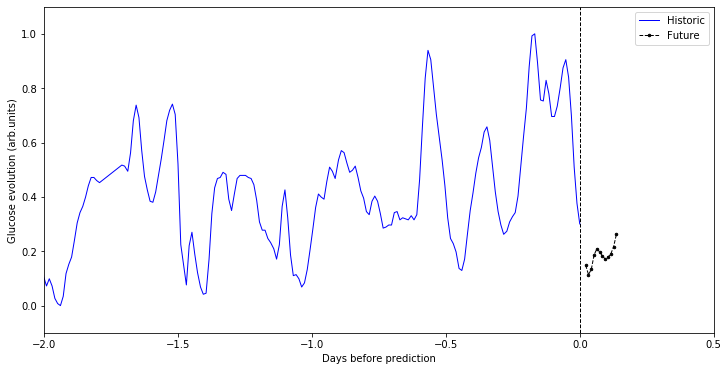

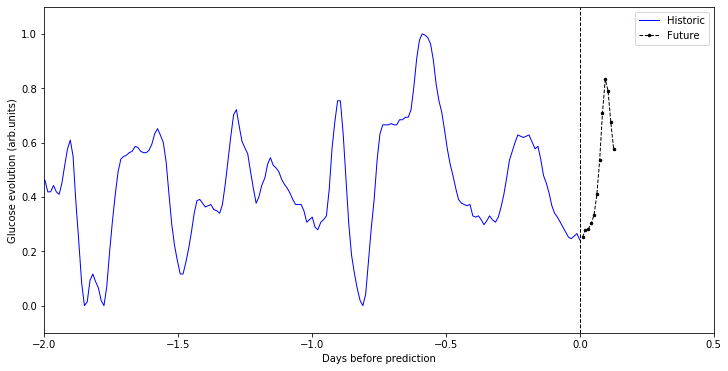

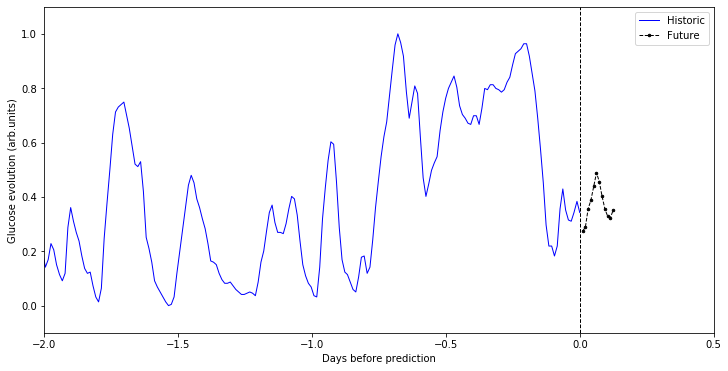

In [0]:
for _ in np.arange(3):

  plt.figure(figsize=(12, 6))

  idx=np.random.randint(low=0, high=train.shape[0])
  xf, xl = train[idx, :history, 0], train[idx, history:history+future, 0]
  yf, yl = train[idx, :history, 3], train[idx, history:history+future, 3]
  
  ymin = yf.min()-0.1
  ymax = yf.max()+0.1

  plt.plot(xf, yf, '-b', markersize=2, linewidth=1, label='Historic')
  plt.plot(xl, yl, '.--k', markersize=5, linewidth=1, label='Future')
  plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

  plt.ylim(ymin, ymax)
  plt.xlim(-history/4/24, 0.5)

  
  plt.ylabel('Glucose evolution (arb.units)')
  plt.xlabel('Days before prediction')
  plt.legend(loc='best')
  plt.show()